In [1]:
import numpy as np
import cmasher as cmr
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import matplotlib.colors as mcolors
import cmasher as cmr

import sys,glob
sys.path.append("/home/561/gp5547/AxionMC")
import gadget as ga


import scipy
import h5py as h5
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['axes.linewidth'] = 1.5
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']}, size=21)

In [2]:
def alpha(r,rho, m, R):
    inte = np.trapz(rho*r**4, r)
    return 4*np.pi*inte/(m*R**2)

def Ebind(r, rho):
    M_encl = np.zeros_like(r)
    for i in range(1, len(r)):
        M_encl[i] = np.trapz(4*np.pi*r[:i+1]**2*rho[:i+1],r[:i+1])

    G = 4.3e-3 # pc*M_sun^-1*(km/s)^2
    ckms = 3e5
    inte = G*(M_encl/r)*(4*np.pi*r**2*rho)*ckms**2
    E = np.trapz(inte, r)
    return E

def beta(r,rho, m, R):
    M_encl = np.zeros_like(r)
    for i in range(1, len(r)):
        M_encl[i] = np.trapz(4*np.pi*r[:i+1]**2*rho[:i+1],r[:i+1])

    inte = np.trapz(rho*r*M_encl, r)
    return 4*np.pi*inte*(R/m**2)

def chi2_nfw(r, rho, params):
    nfw_profile = lambda x, rho0, rs: rho0/((x/rs)*(1+x/rs)**2)
    rho_pred = nfw_profile(r, params[0], params[1])
    chi2 = np.sum(((rho-rho_pred)/rho_pred)**2)
    return chi2/2

def chi2_pl(r, rho, params):
    pl_profile = lambda x, rho0, r0, alpha: rho0*(x/r0)**alpha
    rho_pred = pl_profile(r, params[0], params[1], params[2])
    chi2 = np.sum(((rho-rho_pred)/rho_pred)**2)
    return chi2/3

## NFW only

def alpha_c(c):
    num = c * (c**2/2-3*c/2-3)+3*(1+c)*np.log(1 + c)
    den = c**2*((1+c)*np.log(1+c)-c)
    return num/den

def beta_c(c):
    ff = np.log(1+c)-c/(1+c)
    num = c**3-2*c*(1+c)*ff
    den = 2*(1+c)**2*ff**2
    return num/den

In [3]:
catalogue = '/scratch/hb19/gp5547/ArchivePhD/SpaxMoore/MooreL36/aout/mcdata/iso_z_12.hdf5'
f = h5.File(catalogue, 'r')

0.08924949290060852


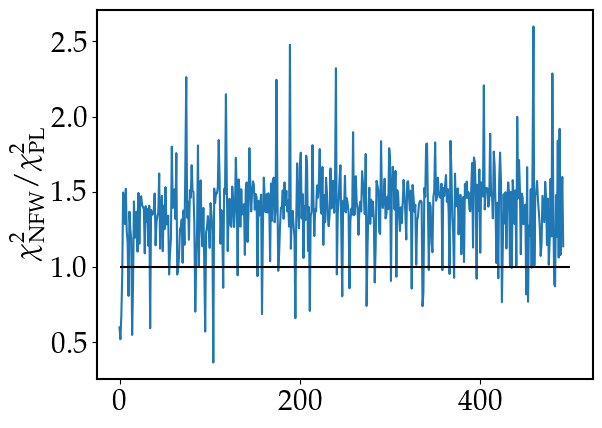

In [4]:
c0, c1 = [],[]
count = 0
for k in list(f.keys())[:-1]:
    radius = f[k].attrs['Radius']
    filt   = np.array(np.where(np.array(f[k+'/rho'])==0)).size
    if filt > 0 or np.array(f[k+'/r'])[0]>5e-2: # Some profiles are too small or noisy and need to be filtered
        continue
    
    x, y = np.array(f[k+'/r'])*radius, np.array(f[k+'/rho'])
    ch2_nfw = chi2_nfw(x,y,f[k+'/nfw_fit'])
    ch2_pl  = chi2_pl(x,y,f[k+'/pl_fit'])
    c0.append(ch2_nfw)
    c1.append(ch2_pl)
    if ch2_nfw<ch2_pl:
        count += 1


print(count/len(c0))
plt.plot(np.array(c0)/np.array(c1))
plt.hlines(1, 0,500, color='k')
plt.ylabel(r'$\chi^2_{\rm NFW}/\chi^2_{\rm PL}$')
plt.show()

$$\alpha^2=\frac{4\pi}{MR^2}\int_0^R{\rm d}r\rho(r) r^4 $$


$$\beta=\frac{4\pi R}{M^2}\int_0^R{\rm d}r\rho(r) r M_{\rm enc}(r), ~~~~~~~M_{\rm enc}(x)=\int_0^x{\rm d}r4\pi r^2\rho(r) $$

<!-- For NFW they take the form

$$\alpha(c)=\frac{c(c^2/2-3c/2-3)+3(1+c)\ln(1+c)}{c^2((1+c)\ln(1+c)-c)}$$ -->

In [5]:
nhalos = 5000
li = sorted(list(f.keys())[:-1], key=lambda x: int(x.split('_')[1]))[:nhalos]


a1a = np.zeros(nhalos)
a2a = np.zeros(nhalos)
be1 = np.zeros(nhalos)
be2 = np.zeros(nhalos)
mm  = np.zeros(nhalos)
rr  = np.zeros(nhalos)
Eb  = np.zeros(nhalos)

count = 0

for j,k in zip(range(nhalos), li):
    filt   = np.array(np.where(np.array(f[k+'/rho'])==0)).size
    if filt > 0:#or np.array(f[k+'/r'])[0]>5e-2: # Some profiles are too small or noisy and need to be filtered
        count += 1
        continue

    mass   = f[k].attrs['Mass']
    mm[j]  = mass
    radius = f[k].attrs['Radius']
    rr[j]  = radius
    rs     = f[k+'/nfw_fit'][1]
    c      = radius/rs
    r, rho = np.array(f[k+'/r'])*radius, np.array(f[k+'/rho'])
    a1 = alpha_c(c)
    a2 = alpha(r,rho,mass,radius)
    Eb[j] = Ebind(r, rho)
    a1a[j] = a1
    a2a[j] = a2
    be1[j] = beta_c(c)
    be2[j] = beta(r,rho,mass, radius)

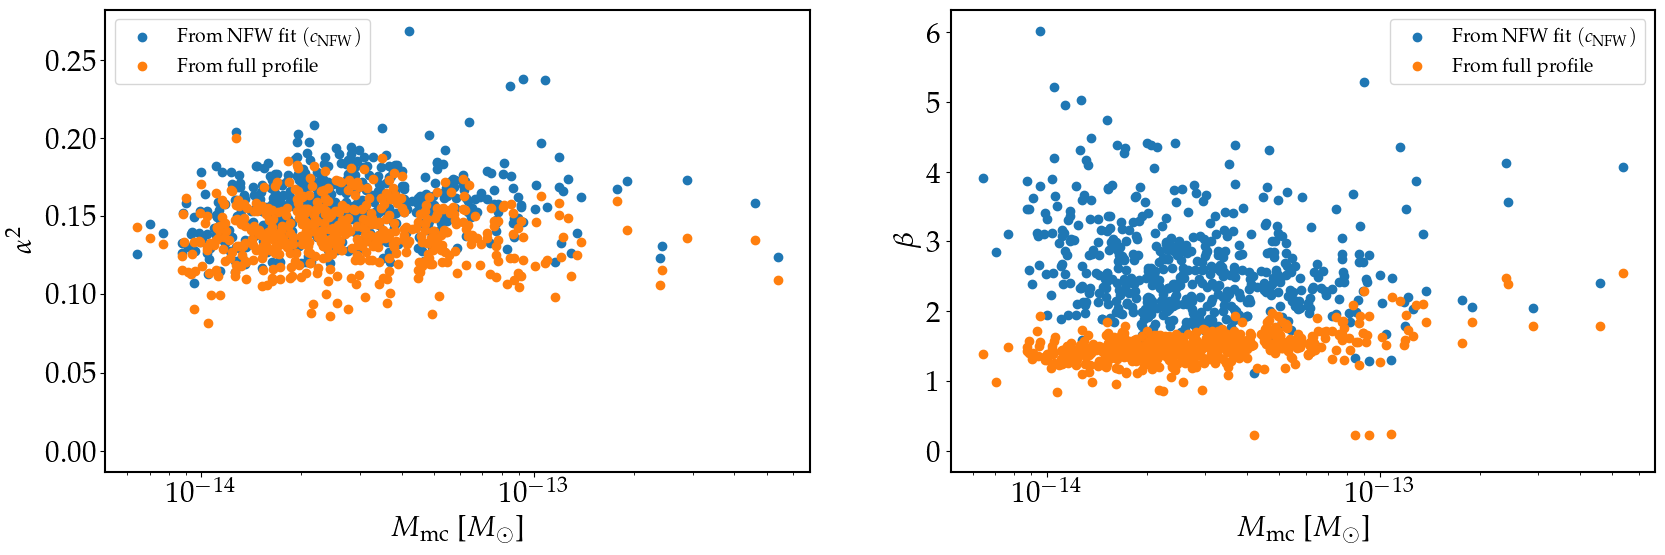

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].scatter(mm, a1a, label=r'From NFW fit $(c_{\rm NFW})$')
ax[0].scatter(mm, a2a, label='From full profile')

ax[1].scatter(mm, be1, label=r'From NFW fit $(c_{\rm NFW})$')
ax[1].scatter(mm, be2, label='From full profile')

for i in range(len(ax)):
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'$M_{\rm mc}$ [$M_{\odot}$]')
    ax[i].legend(fontsize=14, frameon=True)

ax[0].set_ylabel(r'$\alpha^2$')
ax[1].set_ylabel(r'$\beta$')
plt.show()

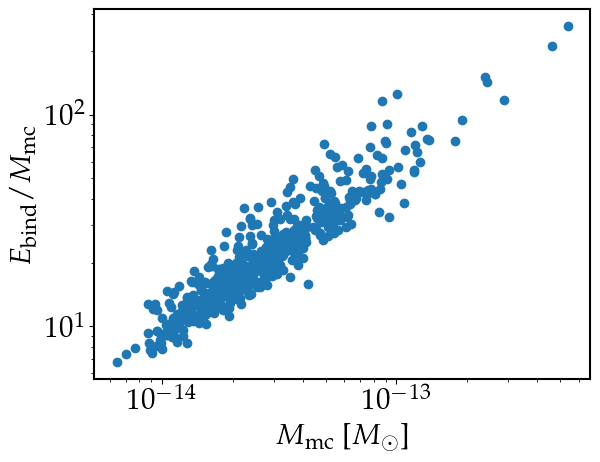

In [7]:
ma = np.where(Eb!=0)
plt.scatter(mm[ma], Eb[ma]/mm[ma])
plt.xlabel(r'$M_{\rm mc}$ [$M_{\odot}$]')
plt.ylabel(r'$E_{\rm bind}/M_{\rm mc}$')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Average density

$$\langle \rho \rangle=\frac{1}{V}\int_0^R{\rm d}rr^2E_{\rm grav}(r), ~~~~~E_{\rm grav}(x)=\int_0^x{\rm d}r\frac{GM_{\rm enc}(r)\rho(r)}{r}$$

In [54]:
## Find average density
k = 'Halo_0'

mass   = f[k].attrs['Mass']
radius = f[k].attrs['Radius']
r, rho = np.array(f[k+'/r'])*radius, np.array(f[k+'/rho'])

M_encl = np.zeros_like(r)
for i in range(1, len(r)):
    M_encl[i] = np.trapz(4*np.pi*r[:i+1]**2*rho[:i+1],r[:i+1])

av_dens = np.trapz(4.3e-3*M_encl*rho*r*(3e5)**2,r)/vol 
av_dens_mr = mass/(4/3*np.pi*radius**3)

print(av_dens_mr/av_dens)

0.04789143421182472


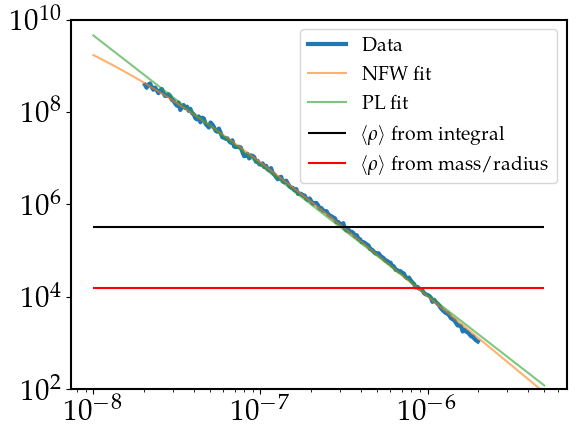

In [55]:
##
xx = np.geomspace(1e-8,5e-6)

a1 = f[k+'/pl_fit'][0]
a2 = f[k+'/pl_fit'][1]
a3 = f[k+'/pl_fit'][2]

n1 = f[k+'/nfw_fit'][0]
n2 = f[k+'/nfw_fit'][1]


mass   = f[k].attrs['Mass']
radius = f[k].attrs['Radius']
x,y = np.array(f[k+'/r'])*radius, np.array(f[k+'/rho'])



plt.loglog(x,y, lw=3, label='Data')
plt.loglog(xx, n1/((xx/n2)*(1+xx/n2)**2), label='NFW fit', alpha=0.6)
plt.loglog(xx, a1*(xx/a2)**(a3), label='PL fit', alpha=0.6)
plt.hlines(av_dens, 1e-8,5e-6, color='k', label=r'$\langle\rho\rangle$ from integral')
plt.hlines(av_dens_mr, 1e-8,5e-6, color='r', label=r'$\langle\rho\rangle$ from mass/radius')
plt.legend(fontsize=14)
plt.ylim(1e2, 1e10)
plt.show()

In [46]:
nhalos = 5000

av1 = np.zeros(nhalos)
av2 = np.zeros(nhalos)

for j,k in zip(range(nhalos), li):
    filt   = np.array(np.where(np.array(f[k+'/rho'])==0)).size
    if filt > 0:#or np.array(f[k+'/r'])[0]>5e-2: # Some profiles are too small or noisy and need to be filtered
        count += 1
        continue
        
    mass   = f[k].attrs['Mass']
    radius = f[k].attrs['Radius']
    r, rho = np.array(f[k+'/r'])*radius, np.array(f[k+'/rho'])

    M_encl = np.zeros_like(r)
    for i in range(1, len(r)):
        M_encl[i] = np.trapz(4*np.pi*r[:i+1]**2*rho[:i+1],r[:i+1])
    
    av_dens = np.trapz(4.3e-3*M_encl*rho*r*(3e5)**2,r)/vol 
    av_dens_mr = mass/(4/3*np.pi*radius**3)
    av1[j] = av_dens
    av2[j] = av_dens_mr

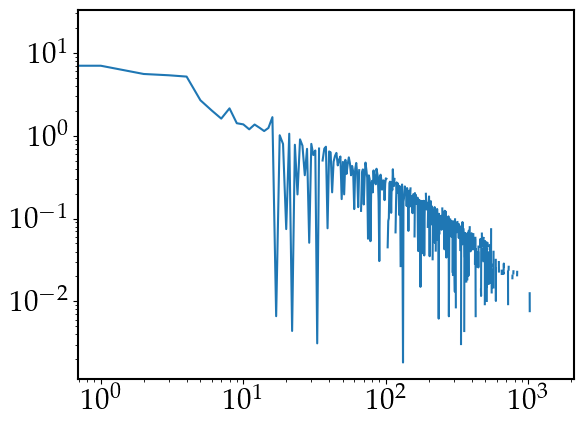

In [56]:
plt.loglog(av1/av2)
plt.show()